# Versão 3.1 - Iteração buscando métricas ainda melhores

Os resultados obtidos foram satisfatórios, mas ainda existem muito espaços para melhoras. Um banco nunca aceitaria um modelo com 30% de risco de inadimplência. Portanto, novas iterações serão feitas buscando melhorar as métricas, como:
1. Engenharia de Atributos
2. Evolução do balanceamento - Mudar o SMOTE para SMOTE-Tomek
3. Testar novos modelos (CatBoost, Voting Classifier)
4. Otimização focada em negócio (Custo do Erro)

1. Importando bibliotecas necessárias

In [23]:
# Manipulação de dados e matemática

import pandas as pd
import numpy as np

# Visualização gráfica

import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e escalonamento

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Balanceamento de Dados (Imbalanced-Learn)

from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# Modelos de Machine Learning
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# Métricas de Avaliação
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score,
    ConfusionMatrixDisplay
)

# Exportação do Modelo
import joblib

In [24]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# 1. Ignorar avisos de mudanças futuras (FutureWarnings)
warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Ignorar avisos de inconsistências de parâmetros (UserWarnings)
warnings.simplefilter(action='ignore', category=UserWarning)

# 3. Ignorar avisos quando o modelo não atinge a convergência (ConvergenceWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

2. Importando o dataframe processado do notebook 2

In [25]:
df = pd.read_parquet('../data/dados_credito_processados.parquet')

df.head()

,idade,sexo_num,valor_conta_poupanca,valor_conta_corrente,salario_anual,valor_emprestimo,prazo_meses,status_inadimplencia,fin_business,fin_car,fin_domestic appliances,fin_education,fin_furniture/equipment,fin_radio/TV,fin_repairs,fin_vacation/others,moradia_free,moradia_own,moradia_rent,comprometimento_renda
0,64.5,1,0.00,30047.52,71436.17,1169.0,6,0,0,0,0,0,0,1,0,0,0,1,0,0.016364
1,22.0,0,93.08,55717.96,49750.60,5951.0,42,1,0,0,0,0,0,1,0,0,0,1,0,0.119617
2,49.0,1,437.57,0.00,30094.48,2096.0,12,0,0,0,0,1,0,0,0,0,0,1,0,0.069647
3,45.0,1,908.93,35947.88,52983.38,7882.0,42,0,0,0,0,0,1,0,0,0,1,0,0,0.148764
4,53.0,1,775.27,33274.01,55310.09,4870.0,24,1,0,1,0,0,0,0,0,0,1,0,0,0.088049


3. Engenharia de Atributos Avançada:

Antes de fazer o procedimento comum de criação de pipelines e treinamentos, vamos fazer uma análise exploratória mais aprofundada, utilizando da engenharia de atributos para buscar métricas melhores.

Para isso, iremos criar as seguintes novas features:
1. Parcela Mensal Estimada
2. Renda Livre Mensal
3. Índice de Cobertura de Liquidez
4. Booleana de Conta Zerada

In [27]:
# Parcela Mensal Estimada

df['parcela_mensal_estimada'] = df['valor_emprestimo']/df['prazo_meses']

# Renda Livre Mensal

df['renda_livre_mensal'] = df['salario_anual']/12 - df['parcela_mensal_estimada']

# Índice de Cobertura de Liquidez

df['cobertura_liquidez'] = (df['valor_conta_corrente'] + df['valor_conta_poupanca']) / df['parcela_mensal_estimada'].replace(0, 1)

# Booleana de Conta Zerada

df['is_conta_corrente_zero'] = (df['valor_conta_corrente'] == 0).astype(int)


In [28]:
df.head()

,idade,sexo_num,valor_conta_poupanca,valor_conta_corrente,salario_anual,valor_emprestimo,prazo_meses,status_inadimplencia,fin_business,fin_car,...,fin_repairs,fin_vacation/others,moradia_free,moradia_own,moradia_rent,comprometimento_renda,parcela_mensal_estimada,renda_livre_mensal,cobertura_liquidez,is_conta_corrente_zero
0,64.5,1,0.00,30047.52,71436.17,1169.0,6,0,0,0,...,0,0,0,1,0,0.016364,194.833333,5758.180833,154.221660,0
1,22.0,0,93.08,55717.96,49750.60,5951.0,42,1,0,0,...,0,0,0,1,0,0.119617,141.690476,4004.192857,393.894082,0
2,49.0,1,437.57,0.00,30094.48,2096.0,12,0,0,0,...,0,0,0,1,0,0.069647,174.666667,2333.206667,2.505172,1
3,45.0,1,908.93,35947.88,52983.38,7882.0,42,0,0,0,...,0,0,1,0,0,0.148764,187.666667,4227.615000,196.395080,0
4,53.0,1,775.27,33274.01,55310.09,4870.0,24,1,0,1,...,0,0,1,0,0,0.088049,202.916667,4406.257500,167.799326,0


4. Limpeza Robusta e Análise Gráfica Aprofundada

Para proceder, podemos analisar se temos outliers dentro das colunas de valor do empréstimo e saldo da conta corrente e se tivermos, os tratamos antes do pré processamento.

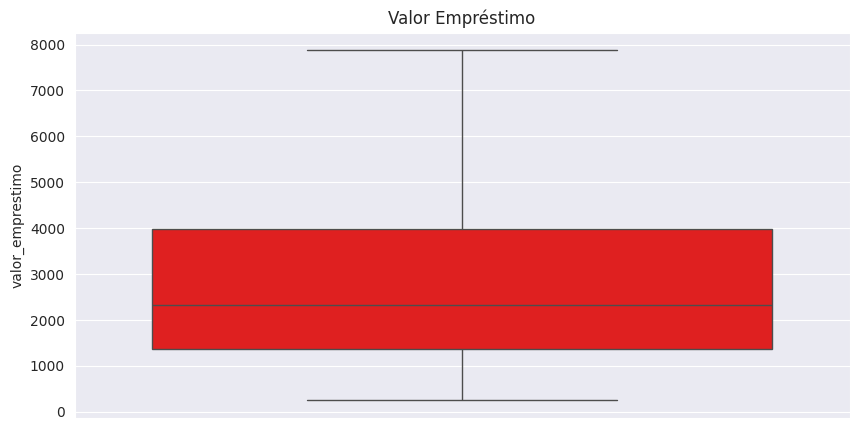

In [29]:
plt.figure(figsize=(10,5))

sns.boxplot(y = df['valor_emprestimo'], color = 'red')
plt.title("Valor Empréstimo")
plt.show()

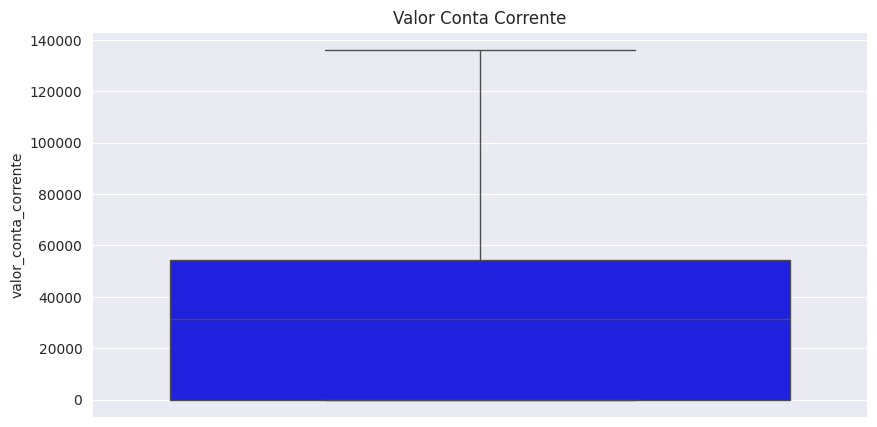

In [30]:
plt.figure(figsize=(10,5))

sns.boxplot(y = df['valor_conta_corrente'], color = 'blue')
plt.title("Valor Conta Corrente")
plt.show()

Através destes gráficos, podemos observar que ambas as colunas estão com assimetrias. Para tratá-las, iremos utilizar a transformação logarítmica presentes no numpy.

In [31]:
colunas = ['valor_emprestimo', 'valor_conta_corrente']

for col in colunas:
    df[f'log_{col}'] = np.log1p(df[col])

df.drop(['valor_emprestimo','valor_conta_corrente' ], axis = 1, inplace = True)
df.head()

,idade,sexo_num,valor_conta_poupanca,salario_anual,prazo_meses,status_inadimplencia,fin_business,fin_car,fin_domestic appliances,fin_education,...,moradia_free,moradia_own,moradia_rent,comprometimento_renda,parcela_mensal_estimada,renda_livre_mensal,cobertura_liquidez,is_conta_corrente_zero,log_valor_emprestimo,log_valor_conta_corrente
0,64.5,1,0.00,71436.17,6,0,0,0,0,0,...,0,1,0,0.016364,194.833333,5758.180833,154.221660,0,7.064759,10.310569
1,22.0,0,93.08,49750.60,42,1,0,0,0,0,...,0,1,0,0.119617,141.690476,4004.192857,393.894082,0,8.691483,10.928076
2,49.0,1,437.57,30094.48,12,0,0,0,0,1,...,0,1,0,0.069647,174.666667,2333.206667,2.505172,1,7.648263,0.000000
3,45.0,1,908.93,52983.38,42,0,0,0,0,0,...,1,0,0,0.148764,187.666667,4227.615000,196.395080,0,8.972464,10.489853
4,53.0,1,775.27,55310.09,24,1,0,1,0,0,...,1,0,0,0.088049,202.916667,4406.257500,167.799326,0,8.491055,10.412562


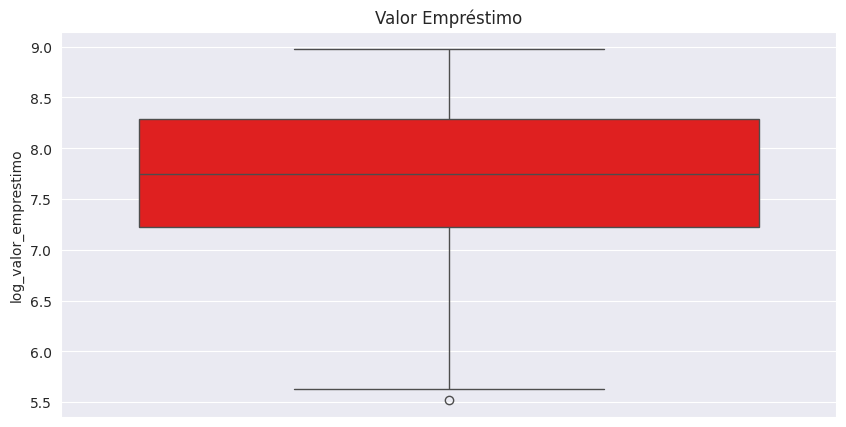

In [32]:
plt.figure(figsize=(10,5))

sns.boxplot(y = df['log_valor_emprestimo'], color = 'red')
plt.title("Valor Empréstimo")
plt.show()

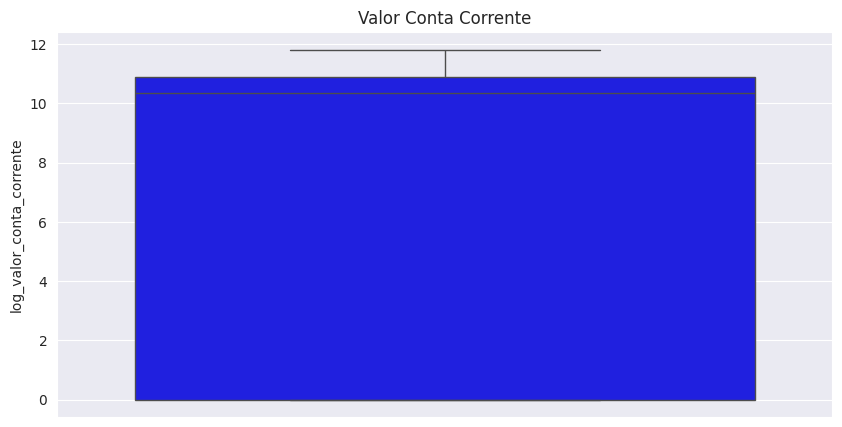

In [33]:
plt.figure(figsize=(10,5))

sns.boxplot(y = df['log_valor_conta_corrente'], color = 'blue')
plt.title("Valor Conta Corrente")
plt.show()

5. Criando a Pipeline de Pré-processamento

In [34]:
X = df.drop(columns = ['status_inadimplencia'])
y = df['status_inadimplencia']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [39]:
resultados = []
melhores_modelos = {}

grids = {
    "Logistic Regression": {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'], # 'saga' é bom para datasets maiores
        'classifier__max_iter': [100, 200]
    },

    "Random Forest": {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__bootstrap': [True, False]
    },

    "XGBoost": {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__colsample_bytree': [0.6, 0.8, 1.0],
        'classifier__gamma': [0, 0.1, 0.2]
    },

    "CatBoost": {
        'classifier__iterations': [500, 1000],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__depth': [4, 6, 8, 10],
        'classifier__l2_leaf_reg': [1, 3, 5, 9],
        'classifier__border_count': [32, 5, 254],
        'classifier__bagging_temperature': [0, 1]
    }
}

modelos = {
    'Logistic Regression' : LogisticRegression(max_iter = 1000),
    'Random Forest' : RandomForestClassifier(random_state=42),
    'XGBoost' : XGBClassifier(random_state=42, verbosity=0 ),
    'CatBoost' : CatBoostClassifier(random_state=42, silent=True)
}

# Verificações antes do treinamento dos modelos
print('Checando NaNs e infinitos em X_train e y_train...')
print('X_train NaNs:', X_train.isnull().sum().sum())
print('X_train infinitos:', np.isinf(X_train).sum().sum())
print('y_train NaNs:', y_train.isnull().sum())
print('y_train valores únicos:', y_train.value_counts().to_dict())

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
print('Distribuição das classes em cada fold:')
for i, (_, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {i}: {y_train.iloc[val_idx].value_counts().to_dict()}")

for nome, modelo in modelos.items():
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('smote', SMOTETomek(random_state=42)),
        ('classifier', modelo)
    ])

    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=grids[nome],
        n_iter=10,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    search.fit(X_train, y_train)
    melhores_modelos[nome] = search.best_estimator_
    resultados.append({
        'Modelo': nome,
        'Melhor F1 (Treino/CV)': search.best_score_,
        'Melhores Parâmetros': search.best_params_
    })

    print(f"✅ {nome} finalizado. F1-Score: {search.best_score_:.4f}")


Checando NaNs e infinitos em X_train e y_train...
X_train NaNs: 0
X_train infinitos: 0
y_train NaNs: 0
y_train valores únicos: {0: 560, 1: 240}
Distribuição das classes em cada fold:
Fold 0: {0: 112, 1: 48}
Fold 1: {0: 112, 1: 48}
Fold 2: {0: 112, 1: 48}
Fold 3: {0: 112, 1: 48}
Fold 4: {0: 112, 1: 48}
✅ Logistic Regression finalizado. F1-Score: 0.5652
✅ Random Forest finalizado. F1-Score: 0.5508
✅ XGBoost finalizado. F1-Score: 0.5658
✅ CatBoost finalizado. F1-Score: nan


In [38]:
df_resultados = pd.DataFrame(resultados).sort_values(by='Melhor F1 (Treino/CV)', ascending = False)
display(df_resultados)

,Modelo,Melhor F1 (Treino/CV),Melhores Parâmetros
2,XGBoost,0.565785,"{'classifier__subsample': 0.6, 'classifier__n_..."
0,Logistic Regression,0.565221,"{'classifier__solver': 'saga', 'classifier__pe..."
1,Random Forest,0.550795,"{'classifier__n_estimators': 100, 'classifier_..."
3,CatBoost,NaN,"{'classifier__learning_rate': 0.01, 'classifie..."
